# Prepare data

In [1]:
# Import data from the text file
import numpy as np

X = np.loadtxt('real_data_experiment/UCI HAR Dataset/train/X_train.txt')
y = np.loadtxt('real_data_experiment/UCI HAR Dataset/train/y_train.txt')


## Visualize

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

n = X.shape[0]
p = X.shape[1]
δ = n/p
L = 2

# Plot a seaborn pairplot of the data
import seaborn as sns
import pandas as pd
df = pd.DataFrame(X)
df['y'] = y
sns.pairplot(df.sample(1000))
plt.show()

# Plot useful seaborn plots of the data
sns.boxplot(data=df.sample(1000))
plt.show()

sns.violinplot(data=df.sample(1000))
plt.show()

sns.heatmap(df.sample(1000).corr())
plt.show()

# Plot a seaborn pairplot of the log-transformed data
df = pd.DataFrame(np.log(X))
df['y'] = y
sns.pairplot(df.sample(1000))
plt.title("Log-transformed data")
plt.show()




## Transform data

δ:  13.105169340463458
Whitened covariance:  [[ 0.9982176  -0.00178252 -0.00178259 ... -0.00178257 -0.00178254
  -0.00178254]
 [-0.00178252  0.99821746 -0.00178258 ... -0.00178255 -0.00178251
  -0.00178253]
 [-0.00178259 -0.00178258  0.99821734 ... -0.00178256 -0.0017826
  -0.00178257]
 ...
 [-0.00178257 -0.00178256 -0.00178256 ...  0.99821746 -0.00178254
  -0.00178256]
 [-0.00178254 -0.00178251 -0.0017826  ... -0.00178254  0.9982172
  -0.00178255]
 [-0.00178254 -0.00178252 -0.00178257 ... -0.00178255 -0.00178255
   0.9982175 ]]
Whitened (unit) covariance:  [[ 0.9982176  -0.00178253 -0.00178259 ... -0.00178257 -0.00178254
  -0.00178254]
 [-0.00178253  0.99821746 -0.00178259 ... -0.00178256 -0.00178251
  -0.00178252]
 [-0.00178259 -0.00178259  0.99821734 ... -0.00178256 -0.0017826
  -0.00178257]
 ...
 [-0.00178257 -0.00178256 -0.00178256 ...  0.99821746 -0.00178254
  -0.00178255]
 [-0.00178254 -0.00178251 -0.0017826  ... -0.00178254  0.9982172
  -0.00178256]
 [-0.00178254 -0.00178253 -0

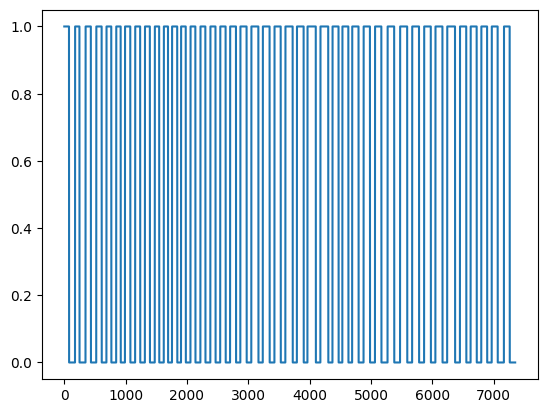

In [2]:
# Whiten the data
import numpy as np
import jax.numpy as jnp
from scipy.linalg import sqrtm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

n = X.shape[0]
p = X.shape[1]
δ = n/p
print("δ: ", δ)

X_white = X - np.mean(X, axis=1).reshape((n, 1))
X_white = jnp.real(jnp.array(X_white @ sqrtm(np.linalg.pinv(1/n * X_white.T @ X_white))))

print("Whitened covariance: ", 1/n * X_white.T @ X_white)

# X_partial_log_white = X - np.mean(X, axis=0)
# X_partial_log_white = jnp.array(X_partial_log_white @ sqrtm(np.linalg.inv(1/n * X_partial_log_white.T @ X_partial_log_white)))

# # Plot a seaborn pairplot of the log-transformed data
# df = pd.DataFrame(X_partial_log_white)
# df['y'] = y
# sns.pairplot(df)
# plt.title("Log-transformed data")
# plt.show()

# Map the covariates to a gaussian distribution using scikit-learn's PowerTransformer
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer()
# X_gaussian = pt.fit_transform(X)

# # Plot a seaborn pairplot of the gaussian-transformed data
# df = pd.DataFrame(X_gaussian)
# df['y'] = y
# sns.pairplot(df.sample(1000))
# plt.title("Gaussian-transformed data")
# plt.show()

# Print the covariance matrix of the gaussian-transformed data
# print("Covariance matrix of the gaussian-transformed data: ", 1/n * X_gaussian.T @ X_gaussian)
# Whiten the data using this covariance matrix
# X_gaussian_white = X_gaussian - np.mean(X_gaussian, axis=0)
# X_gaussian_white = jnp.array(X_gaussian_white @ sqrtm(np.linalg.inv(1/n * X_gaussian.T @ X_gaussian)))
# print("Covariance matrix of the gaussian-transformed data whitened: ", 1/n * X_gaussian_white.T @ X_gaussian_white)

# Set the final data to be used in the analysis
X_prep = X_white
# X_prep = X_gaussian
X_prep = X_prep * np.sqrt(1/n) # Scale appropriately, according to AMP
y_prep = jnp.array(y > 3).astype(int)

print("Whitened (unit) covariance: ", X_prep.T @ X_prep)

print("X_prep: ", X_prep)
print("y_prep: ", y_prep)

plt.plot(y_prep)

# Run AMP

In [9]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import norm_sq_corr, PAL
from amp.marginal_separable_jax_logistic import q, GAMP_full, GAMP_gaussian_clean
import amp.signal_configuration
from amp.signal_configuration import unif_prior_to_η_ϕ, unif_prior_to_η_ϕ_combinations
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
import amp.posterior_logistic
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)


# --- Preliminaries ---

T = 3
σ = 0.1
L = 2
# Changepoint locations
Δ = lambda n: int(n/20)
Lmin = 1
Lmax = L
p_l = 1/L * np.ones(L) # puts equal weight on all number of signals, set None otherwise. Best for estimating size. 
num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ_combinations(Lmin, Lmax, Δ(n), n, p_l = p_l) # Lxn matrix
assert η_arr.shape == (num_valid_configs, Lmax-1) and \
    len(p_η_arr) == num_valid_configs
assert ϕ.shape == (Lmax, n)

# Gaussian Signal Prior
B̃_cov = 1 * np.eye(L)
B̃_cov[0, 1] = 0.0
B̃_cov[1, 0] = 0.0
signal_prior = GaussianSignal(B̃_cov)

B̃ = signal_prior.sample(p)
ρ = 1/δ * 1/p * B̃.T @ B̃
B̂_0 = signal_prior.sample(p)

# Generate the observation vector Y
# X_prep = np.random.normal(0, np.sqrt(1/n), (n, p))
# Θ = X @ B̃
# ε = np.random.rand(n) # uniform dist
C_true = jnp.zeros(n).astype(int)
# Y = q(Θ, jnp.ones(n).astype(int), ε) 

# B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X_prep, y_prep, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
B̂, Θ_t, ν, ν̂  = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X_prep, y_prep, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = False)
κ_T = ν - ν.T @ jnp.linalg.inv(ρ) @ ν

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6616 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6618 [00:00<?, ?it/s]

Change point estimation:  []


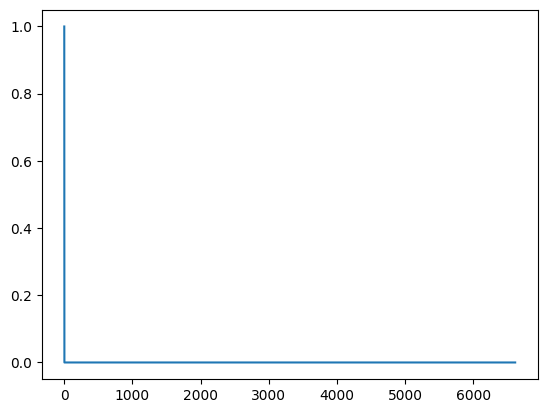

In [11]:
κ_T = ν - ν.T @ jnp.linalg.inv(ρ) @ ν
ψ_arr_amp, η_idx_amp = amp.signal_configuration.η_to_ψ_jax_combinations_mapped(η_arr, n, L)       
post_amp = amp.posterior_logistic.compute_approx_posterior(ψ_arr_amp, Θ_t, y_prep, n, ρ, σ, ν, κ_T)
map_idx_amp = np.argmax(post_amp)
ψ̂ = ψ_arr_amp[map_idx_amp]
η̂ = η_arr[η_idx_amp[map_idx_amp]]
η̂ = η̂[η̂ > 0]
print("Change point estimation: ", η̂)
plt.plot(post_amp)